# Generating OBC and IC for NWA from global MOM6 model output
*James Simkins, based on an [example by Raphael Dussin](https://github.com/ESMG/regionalMOM6_notebooks/blob/master/creating_obc_input_files/CCS1_OBC_from_global_MOM6.ipynb)*

First let's describe the packages we're using:

- xarray: if you're not familiar, better catch up http://xarray.pydata.org/en/stable/
- xesmf: xarray-friendly horizontal remapping based on ESMF library. We will use it to remap data onto boundaries and regional domain. https://xesmf.readthedocs.io/en/latest/
- HCtFlood: horizontal 2D extrapolation package, used to replace NaN on land by closest ocean value. https://github.com/raphaeldussin/HCtFlood
- bottleneck: optimized compute kernels, needed for xr.ffill or xr.bfill. Make sure to have it installed (available through conda/pip)
- GFDL_xr: only a wrapper to xarray open functions with embedded retrieve from tape, can be replaced by xr if not at GFDL. https://github.com/raphaeldussin/GFDL_xr

In [1]:
#gridtools conda library - https://github.com/ESMG/gridtools/blob/main/conda/gridTools.yml
# additional pycnal regridding installed - https://github.com/ESMG/PyCNAL_regridding - with following command after cloning repo -  python -m pip install .
import xarray as xr
import xesmf
import bottleneck
import numpy as np

## 1. Loading SODA model output from the global model

In [2]:
ds = xr.open_dataset("soda3.3.1_5dy_ocean_reg_1981_01_02.nc")

## 2. Load the regional grid

In [3]:
ds_nwa = xr.open_dataset('~/Downloads/nwa_ocean_hgrid.nc')

## 3. Subsetting the domain

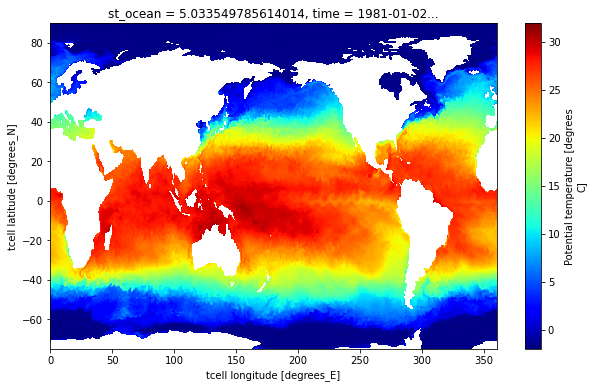

In [4]:
ds['temp'].isel(time=0, st_ocean=0).plot(figsize=[10,6], vmin=-2, vmax=32, cmap='jet')

In [5]:
ds_cut = ds.sel(xt_ocean=slice(np.min(ds_nwa.x.values), np.max(ds_nwa.x.values)), yt_ocean=slice(np.min(ds_nwa.y.values), np.max(ds_nwa.y.values)),
                xu_ocean=slice(np.min(ds_nwa.x.values), np.max(ds_nwa.x.values)), yu_ocean=slice(np.min(ds_nwa.y.values), np.max(ds_nwa.y.values)))

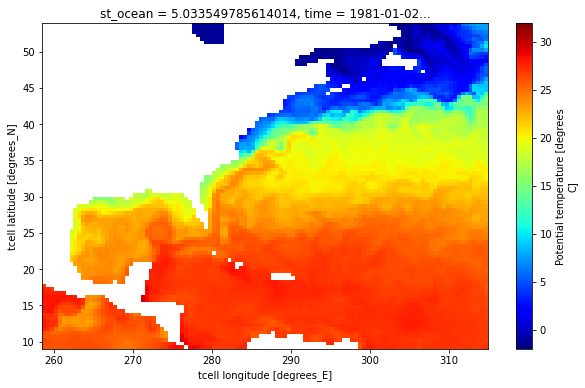

In [6]:
ds_cut['temp'].isel(time=0, st_ocean=0).plot(figsize=[10,6], vmin=-2, vmax=32, cmap='jet')

## 4. Regridding to Open Boundaries

In [7]:
# northern boundary
north = xr.Dataset()
north['lon'] = ds_nwa['x'].isel(nyp=-1)
north['lat'] = ds_nwa['y'].isel(nyp=-1)

# southern boundary
south = xr.Dataset()
south['lon'] = ds_nwa['x'].isel(nyp=0)
south['lat'] = ds_nwa['y'].isel(nyp=0)

# western boundary
west = xr.Dataset()
west['lon'] = ds_nwa['x'].isel(nxp=0)
west['lat'] = ds_nwa['y'].isel(nxp=0)

# eastern boundary
east = xr.Dataset()
east['lon'] = ds_nwa['x'].isel(nxp=-1)
east['lat'] = ds_nwa['y'].isel(nxp=-1)

Using xESMF we can create regridding weights from our subset of the global domain to the different boundaries. A few important things to mention here:

- xesmf requires input datasets coordinates to be named lon/lat, hence the renaming of coordinates. Make sure you're using the coordinate that correspond to the location of your variable on the staggered grid
- since we're using a subset, we need to set the periodicity to False
- we're using the locstream option alloaing to remap directly to a segment. More info here: https://xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html
- The weight generation for tracer data onto the 3 open boudaries are then:

In [8]:
regrid_south = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

In [9]:
regrid_east = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), east, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_east.nc')

In [10]:
temp_south = regrid_south(ds_cut['temp'])

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable temp as the horizontal dimensions for the regridding.
  warnings.warn(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


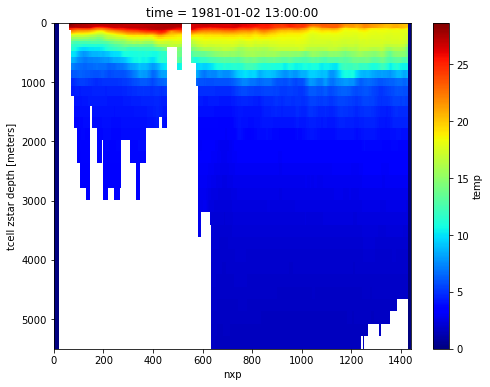

In [11]:

temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

Now let's remove the missing values to make sure we don't have problems with the inconsistency between the coarse global and high resolution regional bathymetries. We can easily perform this operation using xarray ffill (forward fill) or bfill (backward fill), that come from bottleneck. Forward or backward are relative to the array indexing. In this case, we're going to fill forward along locations then forward in depth (surface is index 0):

In [12]:
drowned_temp_south = temp_south.bfill(dim='nxp').ffill(dim='st_ocean')

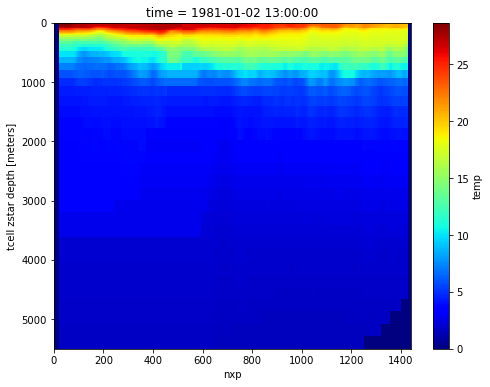

In [13]:
drowned_temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

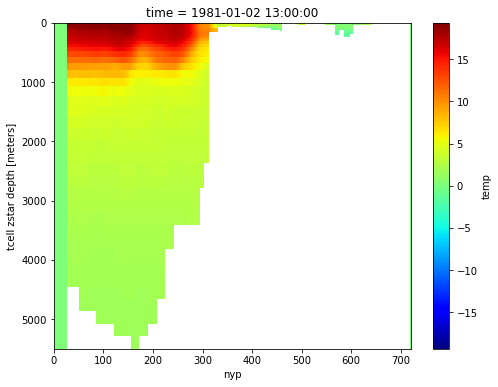

In [14]:
temp_east = regrid_east(ds_cut['temp'])
temp_east.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

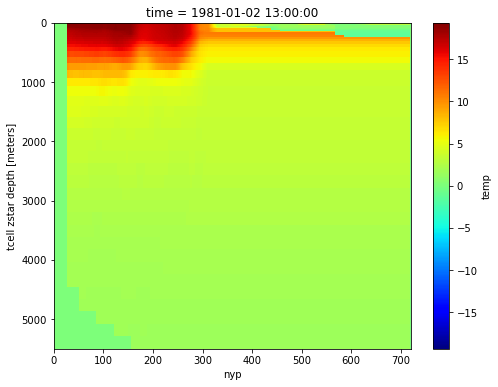

In [15]:
drowned_temp_east = temp_east.ffill(dim='nyp').ffill(dim='st_ocean')
drowned_temp_east.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

## 5. Initial Conditions

Now let's look at how we can create initial conditions for temperature. First we need a xESMF regridder for the whole domain:

In [16]:
regrid_domain = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), ds_nwa.rename({'x': 'lon', 'y': 'lat'}), 'bilinear', 
                                periodic=False, filename='regrid_domain.nc')

Before remapping we're going to extrapolate ocean values onto land, again to deal with inconsistencies between global and regional bathymetry data. But instead of using xarray ffill/bfill, which only work along one axis at the time, we're gonna use a bidimensional extrapolation algo from Kara et al. The extrapolation has been re-coded in python, optimized with numba and wrapped for xarray/dask lazy operation in HCtFlood:

In [17]:
# code courtesy of Raphael Dussin - https://github.com/raphaeldussin/HCtFlood/blob/master/HCtFlood/kara.py

from numba import njit
import numpy as np
from dask.base import tokenize
import dask.array as dsa
import xarray as xr


def flood_kara(data, xdim='lon', ydim='lat', zdim='z', tdim='time',
               spval=1e+15):
    """Apply extrapolation onto land from Kara algo.
    Arguments:
        data {xarray.DataArray} -- input data
    Keyword Arguments:
        xdim {str} -- name of x dimension (default: {'lon'})
        ydim {str} -- name of y dimension (default: {'lat'})
        zdim {str} -- name of z dimension (default: {'z'})
        tdim {str} -- name of time dimension (default: {'time'})
        spval {float} -- missing value (default: {1e+15})
    Returns:
        xarray.DataArray -- result of the extrapolation
    """
    # check for input data shape
    if tdim not in data.dims:
        data = data.expand_dims(dim=tdim)
    if zdim not in data.dims:
        data = data.expand_dims(dim=zdim)

    nrec = len(data[tdim])
    nlev = len(data[zdim])
    ny = len(data[ydim])
    nx = len(data[xdim])
    shape = (nrec, nlev, ny, nx)
    chunks = (1, 1, ny, nx)

    def compute_chunk(zlev, trec):
        data_slice = data.isel({tdim: trec, zdim: zlev})
        return flood_kara_xr(data_slice, spval=spval)[None, None]

    name = str(data.name) + '-' + tokenize(data.name, shape)
    dsk = {(name, rec, lev, 0, 0,): (compute_chunk, lev, rec)
           for lev in range(nlev)
           for rec in range(nrec)}

    out = dsa.Array(dsk, name, chunks,
                    dtype=data.dtype, shape=shape)

    xout = xr.DataArray(data=out, name=str(data.name),
                        coords={tdim: data[tdim],
                                zdim: data[zdim],
                                ydim: data[ydim],
                                xdim: data[xdim]},
                        dims=(tdim, zdim, ydim, xdim))

    # rechunk the result
    xout = xout.chunk({tdim: 1, zdim: nlev, ydim: ny, xdim: nx})

    return xout

def flood_kara_xr(dataarray, spval=1e+15):
    """Apply flood_kara on a xarray.dataarray
    Arguments:
        dataarray {xarray.DataArray} -- input 2d data array
    Keyword Arguments:
        spval {float} -- missing value (default: {1e+15})
    Returns:
        numpy.ndarray -- field after extrapolation
    """

    masked_array = dataarray.squeeze().to_masked_array()
    out = flood_kara_ma(masked_array, spval=spval)
    return out

def flood_kara_ma(masked_array, spval=1e+15):
    """Apply flood_kara on a numpy masked array
    Arguments:
        masked_array {np.ma.masked_array} -- array to extrapolate
    Keyword Arguments:
        spval {float} -- missing value (default: {1e+15})
    Returns:
        out -- field after extrapolation
    """

    field = masked_array.data

    if np.isnan(field).all():
        # all the values are NaN, can't do anything
        out = field.copy()
    else:
        # proceed with extrapolation
        field[np.isnan(field)] = spval
        mask = np.ones(field.shape)
        mask[masked_array.mask] = 0
        out = flood_kara_raw(field, mask)
    return out


def flood_kara_raw(field, mask, nmax=1000):
    """Extrapolate land values onto land using the kara method
    (https://doi.org/10.1175/JPO2984.1)
    Arguments:
        field {np.ndarray} -- field to extrapolate
        mask {np.ndarray} -- land/sea binary mask (0/1)
    Keyword Arguments:
        nmax {int} -- max number of iteration (default: {1000})
    Returns:
        drowned -- field after extrapolation
    """

    ny, nx = field.shape
    nxy = nx * ny
    # create fields with halos
    ztmp = np.zeros((ny+2, nx+2))
    zmask = np.zeros((ny+2, nx+2))
    # init the values
    ztmp[1:-1, 1:-1] = field.copy()
    zmask[1:-1, 1:-1] = mask.copy()

    ztmp_new = ztmp.copy()
    zmask_new = zmask.copy()
    #
    nt = 0
    while (zmask[1:-1, 1:-1].sum() < nxy) and (nt < nmax):
        for jj in np.arange(1, ny+1):
            for ji in np.arange(1, nx+1):

                # compute once those indexes
                jjm1 = jj-1
                jjp1 = jj+1
                jim1 = ji-1
                jip1 = ji+1

                if (zmask[jj, ji] == 0):
                    c6 = 1 * zmask[jjm1, jim1]
                    c7 = 2 * zmask[jjm1, ji]
                    c8 = 1 * zmask[jjm1, jip1]

                    c4 = 2 * zmask[jj, jim1]
                    c5 = 2 * zmask[jj, jip1]

                    c1 = 1 * zmask[jjp1, jim1]
                    c2 = 2 * zmask[jjp1, ji]
                    c3 = 1 * zmask[jjp1, jip1]

                    ctot = c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8

                    if (ctot >= 3):
                        # compute the new value for this point
                        zval = (c6 * ztmp[jjm1, jim1] +
                                c7 * ztmp[jjm1, ji] +
                                c8 * ztmp[jjm1, jip1] +
                                c4 * ztmp[jj, jim1] +
                                c5 * ztmp[jj, jip1] +
                                c1 * ztmp[jjp1, jim1] +
                                c2 * ztmp[jjp1, ji] +
                                c3 * ztmp[jjp1, jip1]) / ctot

                        # update value in field array
                        ztmp_new[jj, ji] = zval
                        # set the mask to sea
                        zmask_new[jj, ji] = 1
        nt += 1
        ztmp = ztmp_new.copy()
        zmask = zmask_new.copy()

        if nt == nmax:
            raise ValueError('number of iterations exceeded maximum, '
                             'try increasing nmax')

    drowned = ztmp[1:-1, 1:-1]

    return drowned

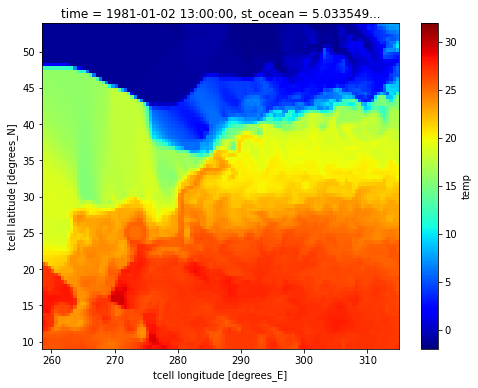

In [18]:
drowned_temp = flood_kara(ds_cut['temp'], xdim='xt_ocean', ydim='yt_ocean', zdim='st_ocean')
drowned_temp.isel(time=0, st_ocean=0).plot(figsize=[8, 6], vmin=-2, vmax=32, cmap='jet')

## Writing Initial Conditions with SODA

This is adapted from - https://github.com/ESMG/PyCNAL_regridding/blob/master/examples/notebooks/Creating_Initial_and_Boundary_conditions_from_SODA3.ipynb

**Required Python Package** - `PyCNAL_regridding` - https://github.com/ESMG/PyCNAL_regridding

To install:

1) `git clone https://github.com/ESMG/PyCNAL_regridding.git`
2) `cd PyCNAL_regridding`
3) `python -m pip install .`

In [ ]:
from PyCNAL_regridding import *
import xarray as xr

# ---------- path to MOM6 grid and SODA3 data ---------------------
momgrd = '/Users/james/Downloads/nwa_ocean_hgrid.nc'

# change this to wherever you've got SODA3
#sodadir = '/Users/raphael/STORAGE/SODA3.3.1/'
sodadir = 'soda3.3.1_5dy_ocean_reg_1981_01_02.nc'

# output directory
outputdir = './'

sodaic = sodadir
ds = xr.open_dataset("/Users/james/Downloads/nwa_ocean_hgrid.nc")

In [20]:
# ---------- define a domain target on MOM grid ---------------------
Nx=int(ds.nx.shape[0])
Ny=int(ds.ny.shape[0])
domain = obc_segment('domain', momgrd,istart=0,iend=Nx,jstart=0,  jend=Ny)

In [21]:
# ---------- define variables on each segment ------------------
temp_domain = obc_variable(domain,'temp',geometry='surface',obctype='radiation')
salt_domain = obc_variable(domain,'salt',geometry='surface',obctype='radiation')
ssh_domain  = obc_variable(domain,'ssh' ,geometry='line'   ,obctype='flather')
vel_domain  = obc_vectvariable(domain,'u','v',geometry='surface',obctype='radiation')

In [22]:
# ---------- interpolate T/S/U/V/SSH from SODA file -------------------
# note that since temp/salt/ssh are on all defined on T-point, we can re-use
# the same interpolator (time-saving)

interp_t2s = temp_domain.interpolate_from(sodaic,'temp',frame=0,depthname='st_ocean', \
                                          coord_names=['xt_ocean','yt_ocean'],method='bilinear')
salt_domain.interpolate_from(sodaic,'salt',frame=0,depthname='st_ocean',coord_names=['xt_ocean','yt_ocean'],\
                             method='bilinear',interpolator=interp_t2s)
ssh_domain.interpolate_from(sodaic ,'ssh' ,frame=0,coord_names=['xt_ocean','yt_ocean'],\
                            method='bilinear',interpolator=interp_t2s)

# but we can't reuse the previous interpolator because u,v are defined at U,V point, not T point
interp_u2s, interp_v2s = vel_domain.interpolate_from(sodaic,'u','v',frame=0,depthname='st_ocean',\
                                                     coord_names_u=['xu_ocean','yu_ocean'], \
                                                     coord_names_v=['xu_ocean','yu_ocean'],method='bilinear')

Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.12332701683044434
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.12961506843566895
Subset source grid : full dimension is  720 330  subset is  514 632 165 259
drown
end drown 0.002580881118774414
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
Subset source grid : full dimension is  720 330  subset is  514 631 165 259
drown
end drown 0.2481389045715332
create regridding for u
create regridding for v
regridding u
regridding v


In [23]:
# ---------- list segments and variables to be written -------
list_segments = [domain]
list_variables = [ssh_domain,temp_domain,salt_domain]
list_vectvariables = [vel_domain]

#----------- time --------------------------------------------
# I think this should be adjusted as defining time in this way creates problems with the netcdf file when loading in xarray, but for now I'll leave it
time = temp_domain.timesrc

# ---------- write to file -----------------------------------
write_ic_file(list_segments,list_variables,list_vectvariables,time,output=outputdir + 'initial_condition_SODA3.nc')

nx,ny,nz = 720.5 360.5 50


In [24]:
# this is how you have to load this because of the timing issue
ic = xr.open_dataset("initial_condition_SODA3.nc", decode_times=False)
#ic.temp[0][0].plot()

# Create OBC files using SODA-based boundary conditions


In [25]:
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import bottleneck
import numpy as np
import subprocess as sp
import os
import glob
import cartopy.crs as ccrs

This example uses monthly output from SODA reanalysis in order to generate boundary conditions for a Northwest Atlantic configuration. Ocean current vectors from a staggered C-grid are co-located at q-points (corners). The grid rotation angles contained in the SODA supergrid files are used to align the currents with the target regional grid.

## Step 1: Open parent and regional model grids

In [26]:

def open_soda_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['yt_ocean','xt_ocean'])
    grid['nyp']=grid['ds'].yu_ocean.data[-1]+1
    grid['nxp']=grid['ds'].xu_ocean.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1,2),yu_ocean=slice(0,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1,2),yu_ocean=slice(0,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1,2),yu_ocean=slice(0,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1,2),yu_ocean=slice(0,nyp+1,2))
    return grid

def open_soda_supergrid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)

    grid['ds']=grid['ds'].drop_dims(['yt_ocean','xt_ocean'])
    grid['nyp']=grid['ds'].yu_ocean.data[-1]+1
    grid['nxp']=grid['ds'].xu_ocean.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    grid['Cu'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    grid['Cv'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    return grid

# these functions have been adapted because the slice shapes didn't work with other functions
def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(0,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(0,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(0,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid

def open_supergrid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(0,nxp+1),nyp=slice(0,nyp+1))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(0,nxp+1),nyp=slice(0,nyp+1))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1),nyp=slice(0,nyp+1))
    grid['Cv'] = grid['ds'].isel(nxp=slice(0,nxp+1),nyp=slice(0,nyp+1))
    return grid

In [27]:

#Note that parent grid uv values are symmetric
path_parent_grid='SODA3_0.5deg_grid.nc'
parent_grid=open_soda_supergrid(path_parent_grid)
path_regional_grid='/Users/james/Downloads/nwa_ocean_hgrid.nc'
regional_grid=open_supergrid(path_regional_grid)

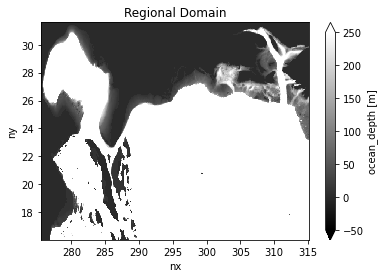

In [28]:
dsr_topo=xr.open_dataset('/Users/james/Downloads/ocean_topog_etopo_unsmoothed_v3.nc')
#dsr_topo = xr.merge([dsr_topo, regional_grid['h']])
dsr_topo.depth.plot(vmax=-50.,vmin=250.,cmap='gist_gray')
txt=plt.title('Regional Domain')

## Step 2: Open parent model data and merge respective grids

In [29]:
def open_dataset(path,fields,grid):
    ds=xr.open_dataset(path,decode_times=False)
    tracer_list=[];uv_list=[]
    for f in fields:
        for fnam,val in zip(f.keys(),f.values()):
            if val=='h':tracer_list.append(fnam)
            if val=='Cu':uv_list.append(fnam)
            if val=='Cv':uv_list.append(fnam)
                
    ds_tr = xr.merge([ds, grid['h']])
    ds_u= xr.merge([ds,grid['Cu']])
    ds_v= xr.merge([ds,grid['Cv']])
    return {'ds_tr':ds_tr,'ds_u':ds_u,'ds_v':ds_v,'tracers':tracer_list,'uv':uv_list}

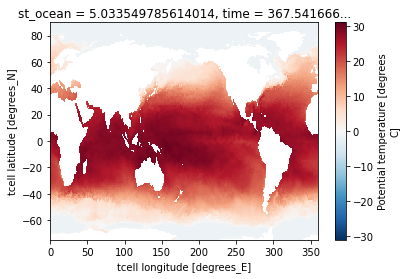

In [30]:
# load the model data
path_model_data='soda3.3.1_5dy_ocean_reg_1981_01_02.nc'

fields=[{'temp':'h'},{'salt':'h'},{'ssh':'h'},{'u':'Cu'},{'v':'Cv'}]
model_data = open_dataset(path_model_data,fields,parent_grid)
model_data['ds_u'].temp[0][0].plot()

## Step 3. Remap velocities to q corners

Since SODA data is already defines velocity at corners (xu_ocean, yu_ocean), we ignore the roll steps found in the original function.

In [31]:
# isn't soda velocity already defined at corners? - this is why we remove the roll feature for velocity_at_corners_soda. When we left the roll feature in, we would remove 180 degrees worth of data
# note we also had ot change x:geolon_c, y:geolat_c, and angle_dx:kmu

def velocity_at_corners_soda(ds_u,ds_v):
    nxp=ds_u.xu_ocean[-1].data+1;nyp=ds_v.yu_ocean[-1].data+1
    #upper-right q points
    u_q=ds_u.u 
    #upper-right q points
    v_q=ds_v.v 
    ds_uvq = xr.Dataset({'u':u_q,'v':v_q},coords={'time':ds_u.time,'lon':parent_grid['q'].geolon_c,'lat':parent_grid['q'].geolat_c,'angle_dx':parent_grid['q'].kmu})
    return ds_uvq

def velocity_at_corners(ds_u,ds_v):
    nxp=ds_u.nxp[-1].data+1;nyp=ds_v.nyp[-1].data+1
    #upper-right q points
    u_q=0.5*(ds_u.u+ds_u.u.roll(roll_coords='yh',yh=-1)).isel(xq=slice(1,nxp))
    #upper-right q points
    v_q=0.5*(ds_v.v+ds_v.v.roll(roll_coords='xh',xh=-1)).isel(yq=slice(1,nyp))
    ds_uvq = xr.Dataset({'u':u_q,'v':v_q},coords={'time':ds_u.time,'lon':parent_grid['q'].x,'lat':parent_grid['q'].y,'angle_dx':parent_grid['q'].angle_dx})
    return ds_uvq



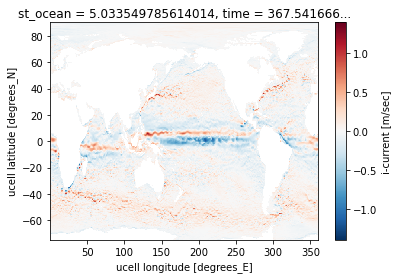

In [32]:
# run velocity_at_corners_soda
ds_u=model_data['ds_u'];ds_v=model_data['ds_v']
model_data['ds_uv']=velocity_at_corners_soda(ds_u,ds_v)

model_data['ds_uv'].u[0][0].plot()

In [33]:
# the following functions are the same except for naming conventions. SODA data uses st_ocean instead of z_l, 
def apply_rotation(u,v,angle_dx,time_slice=slice(0)):
    """Rotate from model space to easterly coordinates"""
    deg_rad=np.pi/180.    
    
    if time_slice is not None:
        t=u.time.isel(time=time_slice)
    else:
        t=u.time
        
    if time_slice is not None:
        ue=np.cos(angle_dx.data*deg_rad)*u.isel(time=time_slice).data-np.sin(angle_dx.data*deg_rad)*v.isel(time=time_slice).data
        vn=np.sin(angle_dx.data*deg_rad)*u.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*v.isel(time=time_slice).data  
    else:
        ue=np.cos(angle_dx.data*deg_rad)*u.data-np.sin(angle_dx.data*deg_rad)*v.data
        vn=np.sin(angle_dx.data*deg_rad)*u.data+np.cos(angle_dx.data*deg_rad)*v.data  
        
    us=ue.shape
    nyp=us[2];nxp=us[3]
    ue=xr.DataArray(ue,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.z_l},dims=('time','z_l','j','i'))
    vn=xr.DataArray(vn,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'z_l':u.z_l},dims=('time','z_l','j','i'))
    return ue,vn

def apply_rotation_soda(u,v,angle_dx,time_slice=slice(0)):
    """Rotate from model space to easterly coordinates"""
    deg_rad=np.pi/180.    
    
    if time_slice is not None:
        t=u.time.isel(time=time_slice)
    else:
        t=u.time
        
    if time_slice is not None:
        ue=np.cos(angle_dx.data*deg_rad)*u.isel(time=time_slice).data-np.sin(angle_dx.data*deg_rad)*v.isel(time=time_slice).data
        vn=np.sin(angle_dx.data*deg_rad)*u.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*v.isel(time=time_slice).data  
    else:
        ue=np.cos(angle_dx.data*deg_rad)*u.data-np.sin(angle_dx.data*deg_rad)*v.data
        vn=np.sin(angle_dx.data*deg_rad)*u.data+np.cos(angle_dx.data*deg_rad)*v.data  
        
    us=ue.shape
    nyp=us[2];nxp=us[3]
    ue=xr.DataArray(ue,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'st_ocean':u.st_ocean},dims=('time','st_ocean','j','i'))
    vn=xr.DataArray(vn,coords={'i':np.arange(1,nxp+1),'j':np.arange(1,nyp+1),'time':t,'st_ocean':u.st_ocean},dims=('time','st_ocean','j','i'))
    
    return ue,vn

In [34]:
# the following functions are the same except for naming conventions. SODA data uses st_ocean instead of z_l, 

def apply_rotation_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    
    return u,v

def apply_rotation_soda_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'st_ocean':ue.st_ocean},dims=('time','st_ocean','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'st_ocean':ue.st_ocean},dims=('time','st_ocean','i'))
    
    return u,v

In [35]:
ds_uvq=model_data['ds_uv']
uq_rot,vq_rot= apply_rotation_soda(ds_uvq.u,ds_uvq.v,ds_uvq.angle_dx,time_slice=None)
ds_uvq_r = xr.Dataset({'u':uq_rot,'v':vq_rot},coords={'time':ds_uvq.time,'lon':ds_uvq.lon,'lat':ds_uvq.lat})
model_data['ds_uv_r']=ds_uvq_r

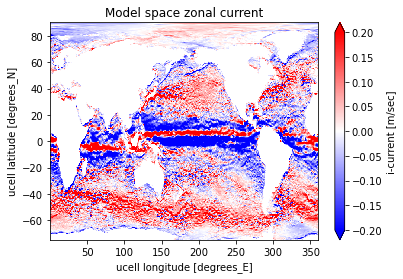

In [36]:
ds_uvq.u.isel(time=0,st_ocean=0).plot(vmin=-.2,vmax=.2,cmap='bwr')
title=plt.title('Model space zonal current')

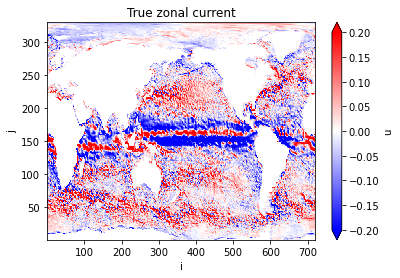

In [37]:
ds_uvq_r.u.isel(time=0,st_ocean=0).plot(vmin=-.2,vmax=.2,cmap='bwr')
title=plt.title('True zonal current')

In [38]:
def uvmag(u,v,z_slice=0):
    spd=np.sqrt(np.squeeze(u.isel(st_ocean=z_slice).data**2.0 + v.isel(st_ocean=z_slice).data**2))
    return xr.DataArray(spd,coords={'i':u.i.data,'j':u.j.data},dims=('j','i'))

<ipython-input-39-2ab9db01df27>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(parent_grid['q'].geolon_c,parent_grid['q'].geolat_c,uvmag_r.data,vmin=0.001,vmax=0.2,cmap=plt.cm.hot)


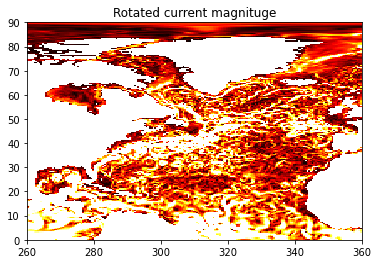

In [39]:
uvmag_r = uvmag(ds_uvq_r.u.isel(time=0),ds_uvq_r.v.isel(time=0))
plt.pcolormesh(parent_grid['q'].geolon_c,parent_grid['q'].geolat_c,uvmag_r.data,vmin=0.001,vmax=0.2,cmap=plt.cm.hot)
plt.xlim(260,360)
plt.ylim(0,90)
title=plt.title('Rotated current magnituge')

## Step 4: Define boundaries for regional domain model

In [40]:
ds_regional=regional_grid['ds']
# northern boundary
north = xr.Dataset()
north['lon'] = ds_regional['x'].isel(nyp=-1)
north['lat'] = ds_regional['y'].isel(nyp=-1)
# southern boundary
south = xr.Dataset()
south['lon'] = ds_regional['x'].isel(nyp=0)
south['lat'] = ds_regional['y'].isel(nyp=0)
# western boundary
west = xr.Dataset()
west['lon'] = ds_regional['x'].isel(nxp=0)
west['lat'] = ds_regional['y'].isel(nxp=0)
# eastern boundary
east = xr.Dataset()
east['lon'] = ds_regional['x'].isel(nxp=-1)
east['lat'] = ds_regional['y'].isel(nxp=-1)

In [41]:
#Load tracers
ds_tr=model_data['ds_tr']
ds_tr = xr.Dataset({'temp':ds_tr.temp,'salt':ds_tr.salt},coords={'lon':ds_tr.geolon_c,'lat':ds_tr.geolat_c})

## Step 5: Calculate remapping weights

For the NWA domain, we only have South and East open boundaries. Therefore, we only calculate these.

In [42]:
#Using nearest neighbor - other options could be used here , e.g. bilinear.
regrid_south_uv = xesmf.Regridder(ds_uvq_r, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_uv.nc')
regrid_east_uv = xesmf.Regridder(ds_uvq_r, east, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_east_uv.nc')

regrid_south_tr = xesmf.Regridder(ds_tr, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_tr.nc')
regrid_east_tr = xesmf.Regridder(ds_tr, east, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_east_tr.nc')

## Step 6: Remap potential temperature,salinity,currents and SSH to boundaries

In [43]:
u_south_r = regrid_south_uv(ds_uvq_r['u'])
v_south_r = regrid_south_uv(ds_uvq_r['v'])
u_east_r = regrid_east_uv(ds_uvq_r['u'])
v_east_r = regrid_east_uv(ds_uvq_r['v'])


u_south,v_south=apply_rotation_soda_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)
ds_uv_south = xr.Dataset({'u':u_south,'v':v_south},coords={'lon':south.lon,'lat':south.lat,'st_ocean':ds_uvq.st_ocean})
fnam='uv_south.nc'
ds_uv_south.time.attrs['calendar']='gregorian'
ds_uv_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

u_east,v_east=apply_rotation_soda_transpose(u_east_r,v_east_r,ds_regional.angle_dx.isel(nxp=ds_regional.nxp[-1]),time_slice=None)
ds_uv_east = xr.Dataset({'u':u_east,'v':v_east},coords={'lon':east.lon,'lat':east.lat,'st_ocean':ds_uvq.st_ocean})
fnam='uv_east.nc'
ds_uv_east.time.attrs['calendar']='gregorian'
ds_uv_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('j', 'i') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('j', 'i') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(


In [44]:
temp_south = regrid_south_tr(ds_tr['temp'])
salt_south = regrid_south_tr(ds_tr['salt'])
ds_tr_south = xr.Dataset({'temp':temp_south,'salt':salt_south})
ds_tr_south.time.attrs['calendar']='gregorian'
fnam='tracers_south.nc'
ds_tr_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

temp_east = regrid_east_tr(ds_tr['temp'])
salt_east = regrid_east_tr(ds_tr['salt'])
ds_tr_east = xr.Dataset({'temp':temp_east,'salt':salt_east})
ds_tr_east.time.attrs['calendar']='gregorian'
fnam='tracers_east.nc'
ds_tr_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable temp as the horizontal dimensions for the regridding.
  warnings.warn(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable salt as the horizontal dimensions for the regridding.
  warnings.warn(


In [45]:
ds_ssh=model_data['ds_tr']
ds_ssh = xr.Dataset({'ssh':ds_ssh.ssh},coords={'lon':ds_ssh.geolon_c,'lat':ds_ssh.geolat_c})

ssh_south = regrid_south_tr(ds_ssh['ssh'])
ds_ssh_south = xr.Dataset({'ssh':ssh_south})
ds_ssh_south.time.attrs['calendar']='gregorian'
fnam='ssh_south.nc'
ds_ssh_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

ssh_east = regrid_east_tr(ds_ssh['ssh'])
ds_ssh_east = xr.Dataset({'ssh':ssh_east})
ds_ssh_east.time.attrs['calendar']='gregorian'
fnam='ssh_east.nc'
ds_ssh_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable ssh as the horizontal dimensions for the regridding.
  warnings.warn(


## Step 7: Inspect the output

(200.0, 0.0)

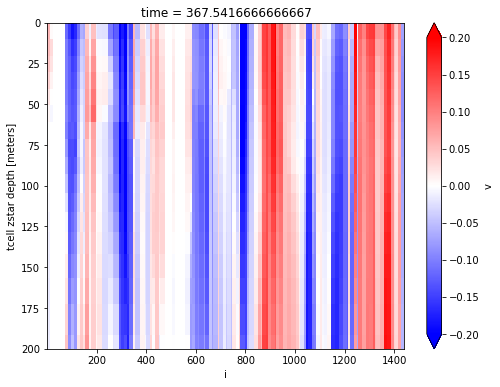

In [46]:
fig=ds_uv_south.v.isel(time=0).plot(figsize=[8, 6], yincrease=False, vmin=-.2,vmax=.2 ,cmap='bwr')
plt.ylim(200,0)

Text(0.5, 1.0, 'Eastern Boundary temperature')

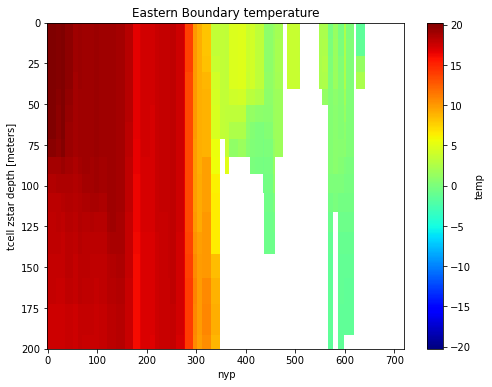

In [47]:
fig=ds_tr_east.temp.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')
plt.ylim(200,0)
plt.title('Eastern Boundary temperature')

In [48]:
params=[]
params.append({'suffix':'_segment_001','dim0':2,'tr_in':'tracers_south.nc','tr_out':'obc_ts_south.nc','uv_in':'uv_south.nc','uv_out':'obc_uv_south.nc','ssh_in':'ssh_south.nc','ssh_out':'obc_ssh_south.nc'})
params.append({'suffix':'_segment_002','dim0':2,'tr_in':'tracers_east.nc','tr_out':'obc_ts_east.nc','uv_in':'uv_east.nc','uv_out':'obc_uv_east.nc','ssh_in':'ssh_east.nc','ssh_out':'obc_ssh_east.nc'})

for pr in params:
    ds=xr.open_dataset(pr['tr_in'],decode_times=False)


## Step 8: Finally some reformatting for MOM6

SODA data has different naming conventions than OM4, so we still have some `st_ocean` variable names in here.

In [49]:
params=[]
params.append({'suffix':'_segment_001','dim0':2,'tr_in':'tracers_south.nc','tr_out':'obc_ts_south.nc','uv_in':'uv_south.nc','uv_out':'obc_uv_south.nc','ssh_in':'ssh_south.nc','ssh_out':'obc_ssh_south.nc'})
params.append({'suffix':'_segment_002','dim0':2,'tr_in':'tracers_east.nc','tr_out':'obc_ts_east.nc','uv_in':'uv_east.nc','uv_out':'obc_uv_east.nc','ssh_in':'ssh_east.nc','ssh_out':'obc_ssh_east.nc'})

for pr in params:
    ds=xr.open_dataset(pr['tr_in'],decode_times=False)
    zl=ds.temp.st_ocean
    zi=0.5*(np.roll(zl,shift=-1)+zl)
    zi[-1]=6500.
    ds['z_i']=zi
    dz=zi-np.roll(zi,shift=1)
    dz[0]=zi[0]
    ds['dz']=dz
    nt=ds.time.shape[0]
    nx=ds.lon.shape[0]
    dz=np.tile(ds.dz.data[np.newaxis,:,np.newaxis],(nt,1,nx))
    da_dz=xr.DataArray(dz,coords=[('time',ds.time),('z_l',ds.st_ocean),('locations',ds.lon)])
    da_dz=da_dz.expand_dims('dim_0',pr['dim0'])
    ds.time.attrs['modulo']=' '
    try:
        da_temp=xr.DataArray(ds.temp.ffill(dim='nxp',limit=None).ffill(dim='st_ocean').fillna(0.))
    except:
        da_temp=xr.DataArray(ds.temp.ffill(dim='nyp',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_temp=da_temp.expand_dims('dim_0',pr['dim0'])
    try:
        da_salt=xr.DataArray(ds.salt.ffill(dim='nxp',limit=None).ffill(dim='st_ocean').fillna(0.))
    except:
        da_salt=xr.DataArray(ds.salt.ffill(dim='nyp',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_salt=da_salt.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'temp'+pr['suffix']:da_temp,'salt'+pr['suffix']:da_salt,'lon':ds.lon,'lat':ds.lat,'dz_temp'+pr['suffix']:da_dz,'dz_salt'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['tr_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['uv_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    da_u=xr.DataArray(ds.u.ffill(dim='i',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_u=da_u.expand_dims('dim_0',pr['dim0'])
    da_v=xr.DataArray(ds.v.ffill(dim='i',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_v=da_v.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'u'+pr['suffix']:da_u,'v'+pr['suffix']:da_v,'lon':ds.lon,'lat':ds.lat,'dz_u'+pr['suffix']:da_dz,'dz_v'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['ssh_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    try:
        da_ssh=xr.DataArray(ds.ssh.ffill(dim='nyp',limit=None).fillna(0.))
    except:
        da_ssh=xr.DataArray(ds.ssh.ffill(dim='nxp',limit=None).fillna(0.))
    da_ssh=da_ssh.expand_dims('dim_0',pr['dim0']-1)
    ds_=xr.Dataset({'ssh'+pr['suffix']:da_ssh,'lon':ds.lon,'lat':ds.lat})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['ssh_out'],unlimited_dims=('time'))